In [2]:
!pip install wordcloud

In [1]:
# imports
import pandas as pd 
import numpy as np
import psycopg2
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 

In [2]:
connection = psycopg2.connect(user="postgres",
                                      password="lambdaschoolgroa",
                                      host="groadb-dev.cbayt2opbptw.us-east-1.rds.amazonaws.com",
                                      port="5432",
                                      database="groa")
cursor = connection.cursor()

In [9]:
# How many total ratings did the user add?
def total_ratings(user_id):
    query = f'SELECT COUNT(*) FROM user_ratings WHERE user_id={user_id}'
    cursor.execute(query)
    total_ratings = cursor.fetchall()[0][0]
    return json.dumps({'ratings':total_ratings})

total_ratings(312517)

'{"ratings": 1610}'

In [10]:
# How many total reviews did the user add?
def total_reviews(user_id):
    query = f'SELECT COUNT(*) FROM user_reviews WHERE user_id={user_id}'
    cursor.execute(query)
    total_reviews = cursor.fetchall()[0][0]
    return json.dumps({'reviews':total_reviews})

total_reviews(312517)

'{"reviews": 79}'

In [11]:
# How many movies did the user mark as watched?
def total_watched(user_id):
    query = f'SELECT COUNT(*) FROM user_watched WHERE user_id={user_id} GROUP BY user_id'
    cursor.execute(query)
    total_watched = cursor.fetchall()[0][0]
    return json.dumps({'watched movies':total_watched})

total_watched(312517)

'{"watched movies": 1140}'

In [14]:
# How many movies did the user add to watchlist?
def total_watchlist(user_id):
    query = f'SELECT COUNT(*) FROM user_watchlist WHERE user_id={user_id}'
    cursor.execute(query)
    total_watchlist = cursor.fetchall()[0][0]
    return json.dumps({'movies added to watchlist':total_watchlist})

total_watchlist(312517)

'{"movies added to watchlist": 1043}'

In [40]:
# Best rated movies
# average between user_ratings.rating and movies.average_rating
def best_rated():
    query = """
        SELECT t.movie_id, t.primary_title, t.start_year, t.genres, t.poster_url,
            ((COALESCE(t.imdb_rating,0) + COALESCE(t.avg_usr_rating,0)) / 
                NULLIF((CASE WHEN t.imdb_rating IS NULL THEN 0 ELSE 1 END + 
                        CASE WHEN t.avg_usr_rating IS NULL THEN 0 ELSE 1 END),0)
            ) AS average
        FROM (
            SELECT m.movie_id, m.primary_title, m.start_year, m.genres, m.poster_url,
                m.average_rating AS imdb_rating, AVG(ur.rating) AS avg_usr_rating
            FROM movies m LEFT JOIN user_ratings ur ON m.movie_id=ur.movie_id
            GROUP BY m.movie_id) t
        ORDER BY average DESC NULLS LAST
        LIMIT 10;
    """
    cursor.execute(query)
    best_rated = cursor.fetchall()
    title=[]
    year=[]
    genres=[]
    poster_url=[]
    rating=[]
    dict={}
    keys=range(10)

    for row in best_rated:
        title.append(row[1])
        year.append(row[2])
        genres.append(row[3])
        poster_url.append(row[4])
        rating.append(row[5])

    for i in keys:
        dict[i]=[title[i], year[i], genres[i], poster_url[i], rating[i]]

    return json.dumps(dict)

best_rated()

'{"0": ["The Accident", 2008, "Comedy,Drama", "/j6GO6qfzUmOisaPerY77o9hqamQ.jpg", 5.0], "1": ["Petersburg\'s tram", 2007, "Documentary,History", null, 5.0], "2": ["Shattered Waves", 2017, "Drama,History", "/z3t1nTP6JWXe9ZyInd8I2MhNWMf.jpg", 5.0], "3": ["Identitas - Uguali ma diversi", 2019, "Documentary", null, 5.0], "4": ["Narcissus", 2015, "Drama", null, 5.0], "5": ["Turandot", 1981, "Musical", "/7w9MlqvjmdXTJ0yh09G4NWTLtu.jpg", 5.0], "6": ["The Maltese Phallus", 1990, "Adult,Comedy", null, 5.0], "7": ["Tote ohne Begr\\u00e4bnis", 1964, "Drama", null, 5.0], "8": ["Der Kaktusgarten", 1967, "\\\\N", null, 5.0], "9": ["Fathallah TV, 10 Years and a Revolution Later", 2019, "Documentary,Drama,Music", "/vvcnCLuRniybMXfiRZ38aEoz3kR.jpg", 5.0]}'

In [3]:
# Last 10 reviews
# takes only first 50 characters of the review_text

def last_reviews():
    query = """
        SELECT DISTINCT m.poster_url, m.primary_title, CONCAT(LEFT(ur.review_text, 50), '...'), ur.date
        FROM user_reviews ur INNER JOIN movies m ON ur.movie_id=m.movie_id
        ORDER BY ur.date DESC
        LIMIT 10;
        """
    cursor.execute(query)
    last_reviews = cursor.fetchall()
    
    poster_url=[]
    title=[]
    review_text=[]
    date=[]
    dict={}
    keys=range(10)

    for row in last_reviews:
        poster_url.append(row[0])
        title.append(row[1])
        review_text.append(row[2])
        date.append(row[3])

    for i in keys:
        dict[i]=[poster_url[i], title[i], review_text[i], date[i].strftime("%m/%d/%Y")]

    return json.dumps(dict)

last_reviews()

'{"0": ["/rYBaXgvTKFS8iZC7Wr8SMomSauQ.jpg", "Bee Movie", "Masterpiece. Perfect. 10/10....", "03/05/2020"], "1": ["/hhPBTAn9b4TYOxc1JYNsX4BFAlW.jpg", "Replicas", "I love cloning technology mixed with brain uploadi...", "02/23/2020"], "2": ["/j4YBuAe8D1jDSiitpq69og9x3Yl.jpg", "Sleeping Beauty", "As a kid, I watched this movie dozens, maybe a hun...", "01/03/2020"], "3": ["/j4YBuAe8D1jDSiitpq69og9x3Yl.jpg", "Sleeping Beauty", "Really nostalgic for this movie. The balletic scor...", "01/03/2020"], "4": ["/7LEI8ulZzO5gy9Ww2NVCrKmHeDZ.jpg", "Midsommar", "Way funnier than I expected. A lot of people will ...", "07/12/2019"], "5": ["/lHV8HHlhwNup2VbpiACtlKzaGIQ.jpg", "Hereditary", "This movie is so scary that it makes other horror ...", "07/10/2019"], "6": ["/ux2dU1jQ2ACIMShzB3yP93Udpzc.jpg", "Us", "The main disappointment for me is that \'Us\' doesn\'...", "03/26/2019"], "7": ["/vt1pFzBs4TMGQXvbmkpEK9NqFLL.jpg", "A Star Is Born", "Judy Garland....", "03/16/2019"], "8": ["/vt1pFzBs4TMGQXvbmkpE

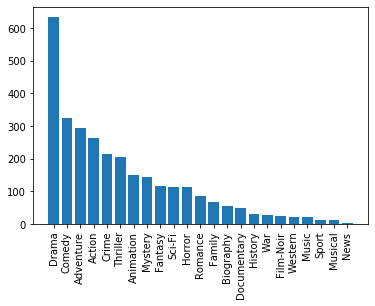

In [45]:
# Favorite genres (function)
user_id=312517
query = f'SELECT genres FROM user_ratings ur INNER JOIN movies m ON ur.movie_id=m.movie_id WHERE user_id={user_id} AND rating>3'
cursor.execute(query)
genres = cursor.fetchall()

genres_list = []

for row in genres:
    genres_list.append(row[0])

df = pd.DataFrame({
    'genres':genres_list
})

genre_counts = {}
for genre_string in df['genres'].values:
        genres = genre_string.split(',')
        for genre in genres:
            if genre in genre_counts:
                genre_counts[genre] += 1
            else:
                genre_counts[genre] = 1
genre_counts = dict(sorted(genre_counts.items(), key= lambda kv:(kv[1], kv[0]), reverse=True))

# Visualize
plt.bar(range(len(genre_counts)), genre_counts.values())
plt.xticks(range(len(genre_counts)), genre_counts.keys(), rotation=90)
plt.show()

In [42]:
# Favorite genres (function)
def favorite_genres(user_id):
    query = f'SELECT genres FROM user_ratings ur INNER JOIN movies m ON ur.movie_id=m.movie_id WHERE user_id={user_id} AND rating>3'
    cursor.execute(query)
    genres = cursor.fetchall()

    genres_list = []

    for row in genres:
        genres_list.append(row[0])

    df = pd.DataFrame({
        'genres':genres_list
    })

    genre_counts = {}
    for genre_string in df['genres'].values:
            genres = genre_string.split(',')
            for genre in genres:
                if genre in genre_counts:
                    genre_counts[genre] += 1
                else:
                    genre_counts[genre] = 1
    return json.dumps(dict(sorted(genre_counts.items(), key= lambda kv:(kv[1], kv[0]), reverse=True)))

favorite_genres(312517)

'{"Drama": 634, "Comedy": 326, "Adventure": 294, "Action": 262, "Crime": 214, "Thriller": 206, "Animation": 150, "Mystery": 144, "Fantasy": 116, "Sci-Fi": 114, "Horror": 114, "Romance": 86, "Family": 66, "Biography": 56, "Documentary": 50, "History": 30, "War": 28, "Film-Noir": 24, "Western": 22, "Music": 22, "Sport": 12, "Musical": 12, "News": 2}'

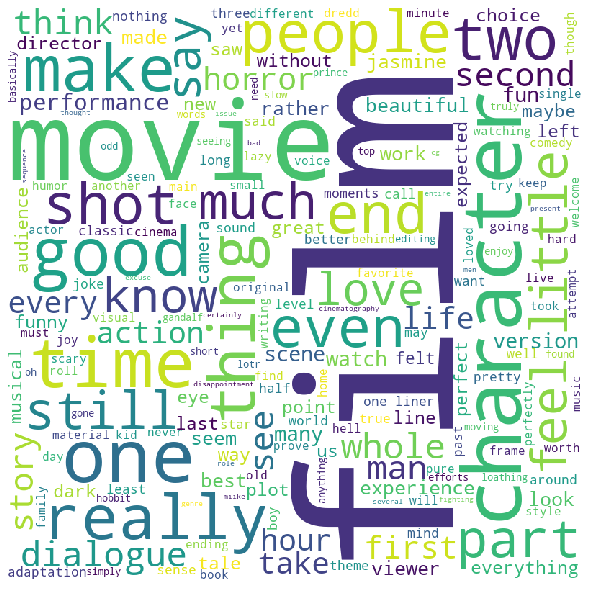

In [20]:
# Most common words used in reviews
user_id = 312517
query = f'SELECT review_text FROM user_reviews WHERE user_id={user_id};'
cursor.execute(query)
result = cursor.fetchall()

reviews_lst = []
for row in result:
    reviews_lst.append(row[0])
reviews = pd.DataFrame({
    'review_text':reviews_lst
})

# Plot the wordcloud
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the df
for val in reviews.review_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

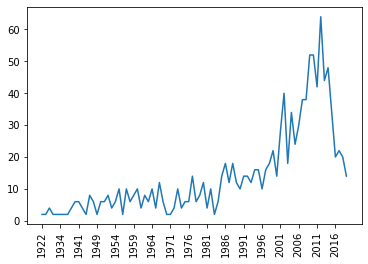

In [80]:
# Prefered release years
user_id = 312517
query = f'SELECT start_year FROM user_ratings ur INNER JOIN movies m ON ur.movie_id=m.movie_id WHERE user_id={user_id} AND rating>3'
cursor.execute(query)
years = cursor.fetchall()

years_list = []

for row in years:
    years_list.append(str(row[0]))

df = pd.DataFrame({
    'years':years_list
})

year_counts = {}
for year in df['years'].values:
    if year in year_counts:
        year_counts[year] += 1
    else:
        year_counts[year] = 1
year_counts = dict(sorted(year_counts.items(), key=lambda x: x[0]))

# Visualize
lists = sorted(year_counts.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.xticks(range(len(year_counts))[0::5], list(year_counts.keys())[0::5], rotation=90)
plt.show()

In [37]:
# Prefered release years (function)
def preferred_years(user_id):
    query = f'SELECT start_year FROM user_ratings ur INNER JOIN movies m ON ur.movie_id=m.movie_id WHERE user_id={user_id} AND rating>3'
    cursor.execute(query)
    years = cursor.fetchall()

    years_list = []

    for row in years:
        years_list.append(str(row[0]))

    df = pd.DataFrame({
        'years':years_list
    })

    year_counts = {}
    for year in df['years'].values:
        if year in year_counts:
            year_counts[year] += 1
        else:
            year_counts[year] = 1
    return json.dumps(dict(sorted(year_counts.items(), key=lambda x: x[0])))

preferred_years(312517)

'{"1922": 2, "1923": 2, "1927": 4, "1928": 2, "1931": 2, "1934": 2, "1935": 2, "1936": 2, "1939": 4, "1940": 6, "1941": 6, "1942": 4, "1944": 2, "1946": 8, "1948": 6, "1949": 2, "1950": 6, "1951": 6, "1952": 8, "1953": 4, "1954": 6, "1955": 10, "1956": 2, "1957": 10, "1958": 6, "1959": 8, "1960": 10, "1961": 4, "1962": 8, "1963": 6, "1964": 10, "1965": 4, "1966": 12, "1967": 6, "1968": 2, "1971": 2, "1972": 4, "1973": 10, "1974": 4, "1975": 6, "1976": 6, "1977": 14, "1978": 6, "1979": 8, "1980": 12, "1981": 4, "1982": 10, "1983": 2, "1984": 6, "1985": 14, "1986": 18, "1987": 12, "1988": 18, "1989": 12, "1990": 10, "1991": 14, "1992": 14, "1993": 12, "1994": 16, "1995": 16, "1996": 10, "1997": 16, "1998": 18, "1999": 22, "2000": 14, "2001": 28, "2002": 40, "2003": 18, "2004": 34, "2005": 24, "2006": 30, "2007": 38, "2008": 38, "2009": 52, "2010": 52, "2011": 42, "2012": 64, "2013": 44, "2014": 48, "2015": 34, "2016": 20, "2017": 22, "2018": 20, "2019": 14}'

In [40]:
# Most recommended genres
# TEST AFTER INSERTING DATA INTO THE DB
def recommended_genres(user_id):
    query = """SELECT genres
        FROM recommendations r 
            INNER JOIN recommendations_movies rm ON r.recommendation_id=rm.recommendation_id
            INNER JOIN movies m ON rm.movie_id=m.movie_id
        WHERE user_id="""+f'{user_id}'
    cursor.execute(query)
    rec_genres = cursor.fetchall()

    rec_genres_list = []

    for row in rec_genres:
        rec_genres_list.append(row[0])

    df = pd.DataFrame({
        'genres':rec_genres_list
    })

    rec_genre_counts = {}
    for rec_genre_string in df['genres'].values:
            rec_genres = rec_genre_string.split(',')
            for rec_genre in rec_genres:
                if rec_genre in rec_genre_counts:
                    rec_genre_counts[genre] += 1
                else:
                    rec_genre_counts[genre] = 1
    return json.dumps(dict(sorted(rec_genre_counts.items(), key= lambda kv:(kv[1], kv[0]), reverse=True)))

recommended_genres(312517)

'{}'

In [41]:
# Most recommended release years
def recommended_years(user_id):
    query = """SELECT start_year
        FROM recommendations r 
            INNER JOIN recommendations_movies rm ON r.recommendation_id=rm.recommendation_id
            INNER JOIN movies m ON rm.movie_id=m.movie_id
        WHERE user_id="""+f'{user_id}'
    cursor.execute(query)
    rec_years = cursor.fetchall()

    rec_years_list = []

    for row in rec_years:
        rec_years_list.append(str(row[0]))

    df = pd.DataFrame({
        'years':rec_years_list
    })

    rec_year_counts = {}
    for rec_year in df['years'].values:
        if rec_year in rec_year_counts:
            rec_year_counts[year] += 1
        else:
            rec_year_counts[year] = 1
    return json.dumps(dict(sorted(rec_year_counts.items(), key=lambda x: x[0])))

recommended_years(312517)

'{}'